<a href="https://colab.research.google.com/github/kareemullah123456789/NLP/blob/main/LSTM_visuals.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Colab already has everything
import torch, torch.nn as nn, matplotlib.pyplot as plt, numpy as np
from ipywidgets import interact, IntSlider

/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127754 (\N{WATER WAVE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


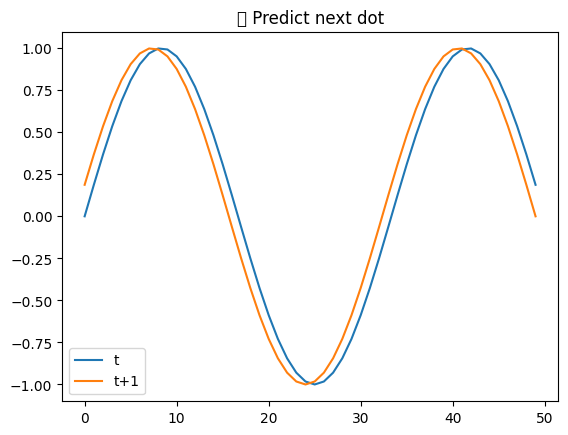

In [ ]:
def make_sine(seq_len=50):
    t = torch.linspace(0, 3*np.pi, seq_len+1)
    return torch.sin(t[:-1]).view(-1,1), torch.sin(t[1:]).view(-1,1)

x, y = make_sine(50)
plt.plot(x, label="t"); plt.plot(y, label="t+1")
plt.title("🌊 Predict next dot"); plt.legend(); plt.show()

In [ ]:
class GateKeeper(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        self.lstm = nn.LSTM(input_size=1, hidden_size=hidden, batch_first=True)
        self.out  = nn.Linear(hidden, 1)

    def forward(self, x):
        out, _ = self.lstm(x)
        return self.out(out)          # (seq_len, 1)

In [ ]:
net = GateKeeper()

def play(seq_len=40, epochs=150):
    x, y = make_sine(seq_len)
    opt = torch.optim.Adam(net.parameters(), 0.01)
    for _ in range(epochs):
        pred = net(x.unsqueeze(0))
        loss = nn.MSELoss()(pred.squeeze(), y.squeeze())
        opt.zero_grad(); loss.backward(); opt.step()

    with torch.no_grad():
        plt.figure(figsize=(8,2.5))
        plt.plot(y, label="True")
        plt.plot(pred.squeeze(), '--', label="LSTM")
        plt.title(f"Length {seq_len}")
        plt.legend(); plt.show()

interact(play,
         seq_len=IntSlider(40, min=20, max=120, step=10),
         epochs=IntSlider(150, min=50, max=400, step=50))

interactive(children=(IntSlider(value=40, description='seq_len', max=120, min=20, step=10), IntSlider(value=15…

<function __main__.play(seq_len=40, epochs=150)>

In [ ]:
def show_states(seq_len=50):
    x, _ = make_sine(seq_len)
    h0 = torch.zeros(1, 1, 16)        # hidden
    c0 = torch.zeros(1, 1, 16)        # cell
    hs, cs = [], []
    for t in range(seq_len):
        _, (h0, c0) = net.lstm(x[t:t+1].unsqueeze(0), (h0, c0))
        hs.append(h0.squeeze().detach().numpy())
        cs.append(c0.squeeze().detach().numpy())

    fig, ax = plt.subplots(1,2, figsize=(11,3))
    ax[0].imshow(np.array(hs).T, cmap='cool', aspect='auto')
    ax[0].set_title("Hidden state hₜ")
    ax[1].imshow(np.array(cs).T, cmap='spring', aspect='auto')
    ax[1].set_title("Cell state cₜ")
    for a in ax: a.set_xlabel("step"); a.set_ylabel("neuron")
    plt.tight_layout(); plt.show()

interact(show_states, seq_len=(20,100,10))

interactive(children=(IntSlider(value=50, description='seq_len', min=20, step=10), Output()), _dom_classes=('w…

<function __main__.show_states(seq_len=50)>

In [ ]:
def gate_magnitudes(seq_len=60):
    lstm = net.lstm
    x, _ = make_sine(seq_len)
    gates_all = []
    h, c = torch.zeros(1,1,16), torch.zeros(1,1,16)
    for t in range(seq_len):
        gates = lstm._backend.RNN.LSTMCell(x[t:t+1], (h, c), *lstm.all_weights)
        i, f, g, o = gates.chunk(4, -1)  # forget, input, etc.
        gates_all.append([i.abs().mean(), f.abs().mean(), g.abs().mean(), o.abs().mean()])
    labels=["Input ⛅", "Forget 🗑️", "Candidate 🌱", "Output 🔓"]
    plt.plot(np.array(gates_all)); plt.legend(labels)
    plt.title("Average gate activity"); plt.ylabel("abs mean"); plt.xlabel("step")
    plt.show()

interact(gate_magnitudes, seq_len=(30,120,10))

interactive(children=(IntSlider(value=60, description='seq_len', max=120, min=30, step=10), Output()), _dom_cl…

<function __main__.gate_magnitudes(seq_len=60)>

In [ ]:
class PlainRNN(nn.Module):
    def __init__(self, hidden=16):
        super().__init__()
        self.rnn = nn.RNN(input_size=1, hidden_size=hidden, batch_first=True)
        self.out = nn.Linear(hidden, 1)
    def forward(self, x):
        return self.out(self.rnn(x)[0])

def battle(seq_len=80):
    models = {"Plain RNN": PlainRNN(), "LSTM": GateKeeper()}
    plt.figure(figsize=(8,3))
    for name, m in models.items():
        opt = torch.optim.Adam(m.parameters(), 0.01)
        x, y = make_sine(seq_len)
        losses=[]
        for _ in range(200):
            loss = nn.MSELoss()(m(x.unsqueeze(0)).squeeze(), y.squeeze())
            loss.backward(); opt.step(); opt.zero_grad()
            losses.append(loss.item())
        plt.plot(losses, label=name)
    plt.title("Loss vs. Epoch (long sequence)")
    plt.yscale('log'); plt.legend(); plt.show()

interact(battle, seq_len=(40,150,10))

interactive(children=(IntSlider(value=80, description='seq_len', max=150, min=40, step=10), Output()), _dom_cl…

<function __main__.battle(seq_len=80)>

In [ ]:
from IPython.display import Markdown as md
md("""
| Gate | Emoji | Job |
|---|---|---|
| **Forget** | 🗑️ | Erase old info |
| **Input** | ⛅ | Add new info |
| **Output** | 🔓 | Decide what to expose |
| **Cell** | 🛤️ | Long-term conveyor belt |
""")


| Gate | Emoji | Job |
|---|---|---|
| **Forget** | 🗑️ | Erase old info |
| **Input** | ⛅ | Add new info |
| **Output** | 🔓 | Decide what to expose |
| **Cell** | 🛤️ | Long-term conveyor belt |
